# Estimate snow depth

In [1]:
import joblib
import json
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from shapely.geometry import shape, Point

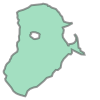

In [2]:
# Load model
model = joblib.load('random_forest_model.pkl')

# Load scalers
X_scaler = joblib.load('X_scaler.pkl')
Y_scaler = joblib.load('Y_scaler.pkl')

with open('ski_areas.geojson', 'r') as f:
    ski_areas = json.load(f)

crystal_mountain_area = [site for site in ski_areas['features'] if site['properties']['name'] == 'Crystal Mountain'][0]
crystal_polygon = shape(crystal_mountain_area['geometry'])
crystal_polygon

In [3]:
!aws s3 cp s3://aimees-snow-project/results.parquet .

download: s3://aimees-snow-project/results.parquet to ./results.parquet


In [4]:
# Load data
results_df = pd.read_parquet('results.parquet')
results_df = results_df.dropna(subset=['fsca'])
results_df['datetime'] = pd.to_datetime(results_df['time'])
results_df['day'] = results_df['datetime'].dt.day
results_df['month'] = results_df['datetime'].dt.month
results_df['year'] = results_df['datetime'].dt.year
results_df.loc[~results_df['fsca'].between(0, 1000), 'fsca'] = None
results_df.head()

,time,longitude,latitude,coastal,blue,green,red,nir08,swir16,swir22,fsca,datetime,day,month,year
0,2024-12-25T18:49:51.253821Z,-121.508679,46.922242,36261.0,35869,34486,34155,33048,17509,18436,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
1,2024-12-25T18:49:51.253821Z,-121.508679,46.921895,36219.0,35757,34552,34083,32874,17493,18473,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
2,2024-12-25T18:49:51.253821Z,-121.508679,46.921547,36237.0,35765,34417,34086,32936,17457,18473,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
3,2024-12-25T18:49:51.253821Z,-121.508679,46.921199,36219.0,35760,34536,34043,32889,17450,18471,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
4,2024-12-25T18:49:51.253821Z,-121.508331,46.923286,36363.0,35863,34542,34192,33038,17589,18608,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024


In [5]:
input_columns = ["red", "green", "blue", "coastal", "nir08", "swir16", "swir22", "fsca", "latitude", "longitude", "month"]
x_input_data = results_df[input_columns]
x_scaled = X_scaler.transform(x_input_data)

In [6]:
%%time
y_pred = model.predict(x_scaled)
y_pred

CPU times: user 1min 3s, sys: 3.48 s, total: 1min 7s
Wall time: 1min 7s


array([0.30294931, 0.29884793, 0.29880184, ..., 0.04207373, 0.04313364,
       0.04207373], shape=(19957490,))

In [7]:
y_scaled = Y_scaler.inverse_transform([[pred] for pred in y_pred])
results_df['snow_depth_prediction'] = y_scaled
results_df.shape

(19957490, 16)

In [8]:
results_df.to_parquet('predictions.parquet')

In [9]:
!aws s3 cp predictions.parquet s3://aimees-snow-project/predictions.parquet

upload: ./predictions.parquet to s3://aimees-snow-project/predictions.parquet
